In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, and_

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Examine the measurement table
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Examine the station table
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurements.date)).scalar()

print("Most recent date:", most_recent_date)

Most recent date: 2017-08-23


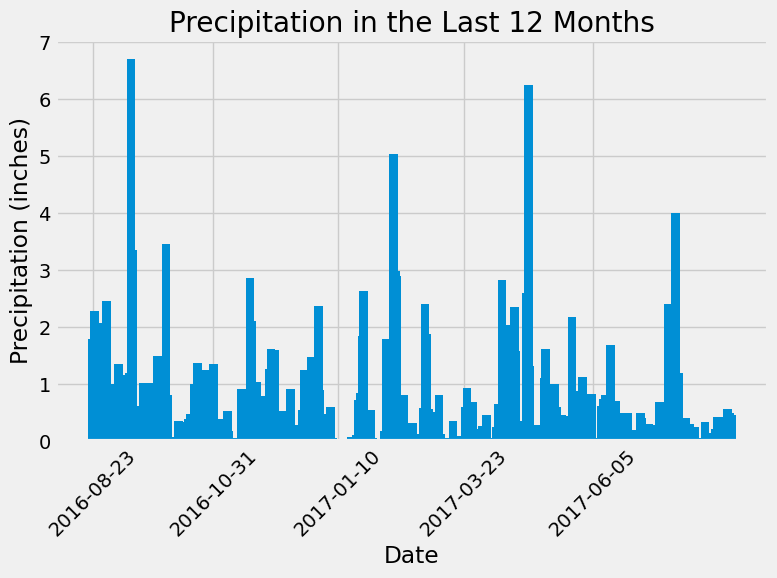

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_earlier_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
recent_year_data = session.query(measurements.date, measurements.prcp).\
filter(and_(measurements.date >= one_year_earlier_date, \
            measurements.date <= most_recent_date)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurements_df = pd.DataFrame(recent_year_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
measurements_df = measurements_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
dates = measurements_df['Date']
precipitation = measurements_df['Precipitation']

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(dates, precipitation, width=5, align='center')

plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
n = len(dates) // 5  # Display every 5th date with help from ChatGPT :)
plt.xticks(dates[::n], rotation=45)  # Use subset of dates for x-axis labels
plt.tight_layout()

plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurements_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(func.distinct(measurements.station))).scalar()
station_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(measurements.station, func.count(measurements.station)).group_by(measurements.station).all()
active_stations = [(station, count) for station, count in station_counts]
sorted_stations = sorted(active_stations, key=lambda x: x[1], reverse=True)
sorted_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_observed_station = session.query(measurements.station, func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).\
    first()[0]
lowest_temp = session.query(func.min(measurements.tobs)).\
    filter(measurements.station == most_observed_station).\
    first()
highest_temp = session.query(func.max(measurements.tobs)).\
    filter(measurements.station == most_observed_station).\
    first()
ave_temp = session.query(func.avg(measurements.tobs)).\
    filter(measurements.station == most_observed_station).\
    first()
most_active_station_temps = [lowest_temp, highest_temp, ave_temp]
most_active_station_temps

[(54.0,), (85.0,), (71.66378066378067,)]

In [21]:
# Join the station name into the measurements data and filter for the station with the most measurements
sel = [measurements.station, stations.name, measurements.date, measurements.prcp, measurements.tobs]
station_join = session.query(*sel).filter(measurements.station == stations.station). \
    filter(measurements.station == most_observed_station).all()
station_join

[('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-01', 0.15, 70.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-02', 0.0, 62.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-03', 0.0, 74.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-04', 0.0, 75.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-05', 0.0, 74.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-06', 0.01, 76.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-07', 0.17, 69.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-08', 0.0, 66.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-09', 0.0, 70.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-10', 0.0, 75.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-11', 0.03, 64.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-12', 0.0, 60.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-13', 0.0, 61.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-14', 0.0, 68.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-15', 0.0, 64.0),
 ('USC

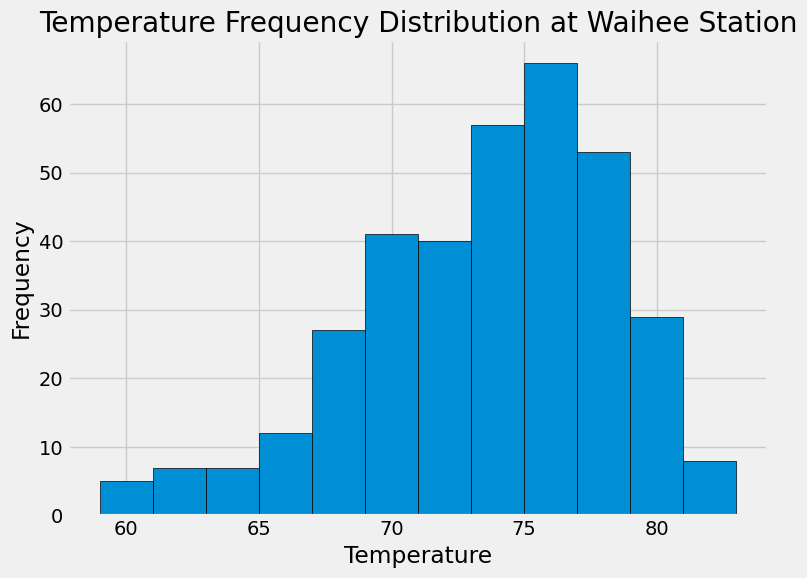

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_year_temps_most_active_station = session.query(measurements.date, measurements.tobs).\
filter(and_(measurements.date >= one_year_earlier_date, \
            measurements.date <= most_recent_date, \
            measurements.station == 'USC00519281')).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
temps_df = pd.DataFrame(recent_year_temps_most_active_station, columns=['Date', 'Temperature'])

# create lists for the x and y axes
dates = temps_df['Date']
temperature = temps_df['Temperature']

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.hist(temperature, bins=12, edgecolor='black') 

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Frequency Distribution at Waihee Station')

plt.tight_layout()
plt.show()

# Close Session

In [48]:
# Close Session
session.close()